### 0. Import Modules

In [5]:
from modules import *
%matplotlib widget
# %matplotlib inline
# %matplotlib notebook
datapicker = create_datapicker()

### 1. Full Loop to Extract Environmental Means

In [ ]:
import os
import pandas as pd
from openpyxl import Workbook
from pythermalcomfort.models import utci
import numpy as np

# ---------------------------------------------------------------------
# Initialize the Excel workbook and sheet
wb = Workbook()
ws = wb.active
ws.append(["Participant Name", "Session Name", "Status", "Radiant Temperature"])

# Path information
sourcedata = r'Z:\Exp_4-outdoor_walk\lisbon\sourcedata\data'
logdata    = r'Z:\Exp_4-outdoor_walk\lisbon\sourcedata\supp\log'

# To store the mean values for each session
all_means = []

# ---------------------------------------------------------------------
# FUNCTIONS
def process_session(session_path, participant_name, session_name):
    
    global all_means  # Declare all_means as global
    data_path = os.path.join(session_path)
    try:
        datapicker.reset(path=data_path)
        create_dataset(datapicker=datapicker)
        status = 1  # Success
    except Exception as e:
        status = 0  # Failed
    
    radiant_temp_status = 0  # Default to 0 if not found or if all zeros

    if status == 1:
        # Generate the sessions.tsv file
        geodata = datapicker.geodata  # Retrieve geodata
        create_geodata(geodata)

        # Get GPS coordinates, integrate them into geodata, and export to csv
        coords = datapicker.geodata.geometry.get_coordinates(include_z=True)
        coords.rename(columns={'y': 'latitude', 'x': 'longitude', 'z': 'elevation'}, inplace=True)
        geodata = geodata.join(coords).drop(columns=['geometry'])
        geodata.to_csv(os.path.join(logdata, f"sub-{participant_name}_ses-{session_name}_geodata.csv"), index=False)

        # Save the full geodata to an Excel file in the log directory
        log_folder = os.path.join(logdata, f"sub-{participant_name}", f"ses-{session_name}")
        os.makedirs(log_folder, exist_ok=True)
        geodata_file = os.path.join(log_folder, f"sub-{participant_name}_ses-{session_name}_geodata.xlsx")
        geodata.to_excel(geodata_file, index=False)
        print(f"Geodata saved to: {geodata_file}")

        # Check if the radiant temperature column exists and contains non-zero values
        if 'tk_thermocouple_temperature_value' in geodata:
            if geodata['tk_thermocouple_temperature_value'].sum() != 0:
                radiant_temp_status = 1  # Non-zero values exist
        
        # Log the result
        ws.append([participant_name, session_name, status, radiant_temp_status])

        # Compute the mean, median, variance, and standard deviation of the numeric columns
        numeric_means = geodata.mean(numeric_only=True).to_dict()
        numeric_median = geodata.median(numeric_only=True).to_dict()
        numeric_variance = geodata.var(numeric_only=True).to_dict()
        numeric_std = geodata.std(numeric_only=True).to_dict()
        numeric_stats = {**numeric_means, **numeric_median, **numeric_variance, **numeric_std}
        # Export to a CSV file
        numeric_stats_df = pd.DataFrame(numeric_stats, index=[0])
        numeric_stats_file = os.path.join(log_folder, f"sub-{participant_name}_ses-{session_name}_numeric_stats.csv")
        numeric_stats_df.to_csv(numeric_stats_file, index=False)
        print(f"Numeric stats saved to: {numeric_stats_file}")

        # Append the mean values to the all_means list
        numeric_means['participant'] = participant_name
        numeric_means['session'] = session_name
        all_means.append(numeric_means)
    
    # Log the radiant_temp_status result
    ws.append([participant_name, session_name, status, radiant_temp_status])


def create_geodata(geodata):
    """Compute UTCI across the whole time series."""
    
    # Define custom parameters
    humidity = geodata['tk_humidity_humidity_value'] / 100  # in fraction
    wind_speed = np.sqrt(geodata['atmos_northwind_value']**2 + geodata['atmos_eastwind_value']**2)  # m/s (~2.5 m of elevation)
    temp_atmos = geodata['atmos_airtemperature_value']  # in ºC
    temp_tk = geodata['tk_airquality_temperature_value'] / 100  # in ºC
    temp_tk_ptc = geodata['tk_ptc_airtemp_value'] / 100  # in ºC
    temp_radiant = geodata['tk_thermocouple_temperature_value'] / 100  # in ºC

    # Assign custom parameters to the geodata attribute
    geodata['humidity'] = humidity
    geodata['wind_speed'] = wind_speed
    geodata['temp_atmos'] = temp_atmos
    geodata['temp_tk'] = temp_tk
    geodata['temp_tk_ptc'] = temp_tk_ptc
    geodata['temp_radiant'] = temp_radiant

    # Compute the UTCI
    geodata['utci'] = utci(tdb=temp_atmos, tr=temp_radiant, v=wind_speed, rh=humidity)

# ---------------------------------------------------------------------
# MAIN SCRIPT
processed_participants = 0

for participant_folder in os.listdir(sourcedata):
    if participant_folder.startswith("OE"):
        participant_path = os.path.join(sourcedata, participant_folder)
        for session_folder in os.listdir(participant_path):
            session_path = os.path.join(participant_path, session_folder)
            if os.path.isdir(session_path):
                process_session(session_path, participant_folder, session_folder)

        processed_participants += 1
        if processed_participants >= 3:
            break  # Stop after processing 2 participants

# Save the Excel file with the updated status in the log directory
result_file = os.path.join(logdata, "session_processing_results.xlsx")
wb.save(result_file)

# Save the mean values to a final CSV file
if all_means:
    final_means_df = pd.DataFrame(all_means)
    final_means_file = os.path.join(logdata, "final_means.csv")
    final_means_df.to_csv(final_means_file, index=False)
    print(f"Final CSV file with mean values saved to: {final_means_file}")
else:
    print("No valid data found to compute mean values.")


Test

In [ ]:
import os
import pandas as pd
from openpyxl import Workbook
from pythermalcomfort.models import utci
import numpy as np

# ---------------------------------------------------------------------
# Initialize the Excel workbook and sheet for logging
workbook = Workbook()
worksheet = workbook.active
worksheet.append(["Participant ID", "Session ID", "Processing Status", "Radiant Temp Status"])

# Path configurations
SOURCE_DATA_PATH = r'Z:\Exp_4-outdoor_walk\lisbon\sourcedata\data'
LOG_DATA_PATH = r'Z:\Exp_4-outdoor_walk\lisbon\sourcedata\supp\log'

# List to store mean values for each session
all_session_means = []

# ---------------------------------------------------------------------
# FUNCTIONS

def process_session(session_dir, participant_id, session_id):
    """
    Process a single session's data, compute statistics, and log results.
    """
    global all_session_means  # Allow modification of the global list

    # Attempt to process the dataset
    try:
        datapicker.reset(path=session_dir)
        create_dataset(datapicker=datapicker)
        processing_status = 1  # Success
    except Exception as e:
        print(f"Error processing session {session_id} for participant {participant_id}: {e}")
        processing_status = 0  # Failed

    # Default radiant temperature status
    radiant_temp_status = 0

    if processing_status == 1:
        # Retrieve geospatial data
        geodata = datapicker.geodata
        compute_utci(geodata)

        # Extract and rename GPS coordinates
        coords = geodata.geometry.get_coordinates(include_z=True)
        coords.rename(columns={'y': 'latitude', 'x': 'longitude', 'z': 'elevation'}, inplace=True)
        geodata = geodata.join(coords).drop(columns=['geometry'])

        # Export geodata to CSV
        geodata_csv_path = os.path.join(LOG_DATA_PATH, f"sub-{participant_id}_ses-{session_id}_geodata.csv")
        geodata.to_csv(geodata_csv_path, index=False)

        # Save geodata to an Excel file in the participant's log directory
        participant_log_dir = os.path.join(LOG_DATA_PATH, f"sub-{participant_id}", f"ses-{session_id}")
        os.makedirs(participant_log_dir, exist_ok=True)
        geodata_excel_path = os.path.join(participant_log_dir, f"sub-{participant_id}_ses-{session_id}_geodata.xlsx")
        geodata.to_excel(geodata_excel_path, index=False)
        print(f"Geodata saved to: {geodata_excel_path}")

        # Check for radiant temperature data
        if 'tk_thermocouple_temperature_value' in geodata.columns:
            if geodata['tk_thermocouple_temperature_value'].sum() != 0:
                radiant_temp_status = 1  # Radiant temperature data available

        # Compute statistical metrics
        numeric_columns = geodata.select_dtypes(include=[np.number])
        stats = {
            'mean': numeric_columns.mean().to_dict(),
            'median': numeric_columns.median().to_dict(),
            'variance': numeric_columns.var().to_dict(),
            'std_dev': numeric_columns.std().to_dict()
        }

        # Export statistics to CSV
        stats_df = pd.DataFrame(stats)
        stats_csv_path = os.path.join(participant_log_dir, f"sub-{participant_id}_ses-{session_id}_stats.csv")
        stats_df.to_csv(stats_csv_path, index=False)
        print(f"Statistical data saved to: {stats_csv_path}")

        # Append mean values to the global list
        session_means = stats['mean']
        session_means['participant_id'] = participant_id
        session_means['session_id'] = session_id
        all_session_means.append(session_means)

    # Log the processing results
    worksheet.append([participant_id, session_id, processing_status, radiant_temp_status])

def compute_utci(geodata):
    """
    Compute the Universal Thermal Climate Index (UTCI) for the given geodata.
    """
    # Calculate custom parameters
    geodata['humidity'] = geodata['tk_humidity_humidity_value'] / 100  # Convert to fraction
    geodata['wind_speed'] = np.sqrt(
        geodata['atmos_northwind_value']**2 + geodata['atmos_eastwind_value']**2
    )  # Wind speed in m/s
    geodata['temp_atmos'] = geodata['atmos_airtemperature_value']  # Atmospheric temperature in °C
    geodata['temp_tk'] = geodata['tk_airquality_temperature_value'] / 100  # TK temperature in °C
    geodata['temp_tk_ptc'] = geodata['tk_ptc_airtemp_value'] / 100  # PTC air temperature in °C
    geodata['temp_radiant'] = geodata['tk_thermocouple_temperature_value'] / 100  # Radiant temperature in °C

    # Compute UTCI
    geodata['utci'] = utci(
        tdb=geodata['temp_atmos'],
        tr=geodata['temp_radiant'],
        v=geodata['wind_speed'],
        rh=geodata['humidity'] * 100  # Convert back to percentage
    )

def get_session_id(session_dir):
    """
    Retrieve the session ID from a metadata file or other means.
    If not available, return the session directory name.
    """
    # Placeholder for session ID retrieval logic
    # For example, read from a 'session_info.txt' file inside the session directory
    session_info_path = os.path.join(session_dir, 'session_info.txt')
    if os.path.exists(session_info_path):
        with open(session_info_path, 'r') as file:
            session_id = file.read().strip()
            return session_id
    else:
        # If no metadata file, use the directory name as session ID
        return os.path.basename(session_dir)

# ---------------------------------------------------------------------
# MAIN SCRIPT

def main():
    max_participants_to_process = 3
    participants_processed = 0

    for participant_folder in os.listdir(SOURCE_DATA_PATH):
        if participant_folder.startswith("OE"):
            participant_id = participant_folder  # Use the folder name as participant ID
            participant_path = os.path.join(SOURCE_DATA_PATH, participant_folder)

            for session_folder in os.listdir(participant_path):
                session_dir = os.path.join(participant_path, session_folder)
                if os.path.isdir(session_dir):
                    # Retrieve the actual session ID
                    session_id = get_session_id(session_dir)
                    process_session(session_dir, participant_id, session_id)

            participants_processed += 1
            if participants_processed >= max_participants_to_process:
                break  # Stop processing after the specified number of participants

    # Save the Excel log
    excel_log_path = os.path.join(LOG_DATA_PATH, "session_processing_results.xlsx")
    workbook.save(excel_log_path)
    print(f"Processing log saved to: {excel_log_path}")

    # Save the mean values to a final CSV file
    if all_session_means:
        final_means_df = pd.DataFrame(all_session_means)
        final_means_csv_path = os.path.join(LOG_DATA_PATH, "final_session_means.csv")
        final_means_df.to_csv(final_means_csv_path, index=False)
        print(f"Final CSV file with mean values saved to: {final_means_csv_path}")
    else:
        print("No valid data found to compute mean values.")

if __name__ == "__main__":
    main()


Error processing session Lisbon_Restelo_sub-OE118003_2024-10-04T103731Z for participant OE003: [Errno 22] Invalid argument
Processing log saved to: Z:\Exp_4-outdoor_walk\lisbon\sourcedata\supp\log\session_processing_results.xlsx
Final CSV file with mean values saved to: Z:\Exp_4-outdoor_walk\lisbon\sourcedata\supp\log\final_session_means.csv


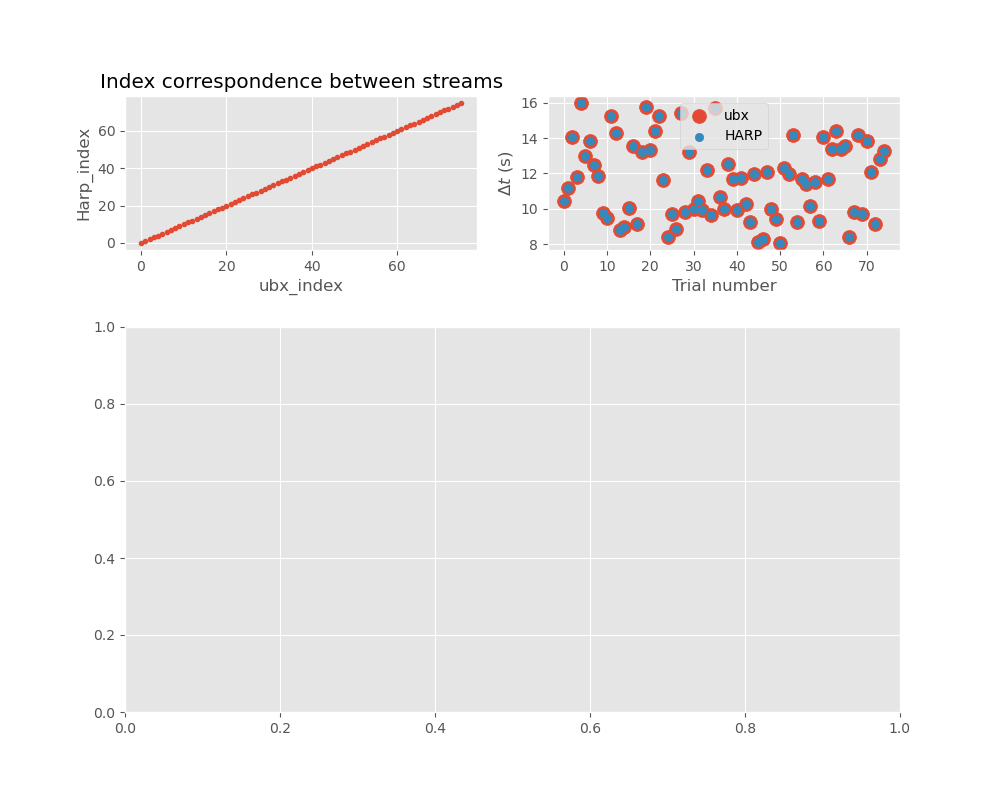

In [8]:
import os
import pandas as pd
from openpyxl import Workbook
from pythermalcomfort.models import utci
import numpy as np

# ---------------------------------------------------------------------
# Initialize the Excel workbook and sheet for logging
workbook = Workbook()
worksheet = workbook.active
worksheet.append(["Participant ID", "Session ID", "Processing Status", "Radiant Temp Status"])

# Path configurations
SOURCE_DATA_PATH = r'Z:\Exp_4-outdoor_walk\lisbon\sourcedata\data'
LOG_DATA_PATH = r'Z:\Exp_4-outdoor_walk\lisbon\sourcedata\supp\log'

# List to store mean values for each session
all_session_means = []

# ---------------------------------------------------------------------
# FUNCTIONS

def process_session(session_dir, participant_id, session_id):
    """
    Process a single session's data, compute statistics, and log results.
    """
    global all_session_means  # Allow modification of the global list

    # Attempt to process the dataset
    try:
        # Assume datapicker and create_dataset are defined elsewhere
        datapicker.reset(path=session_dir)
        create_dataset(datapicker=datapicker)
        processing_status = 1  # Success
    except Exception as e:
        print(f"Error processing session {session_id} for participant {participant_id}: {e}")
        processing_status = 0  # Failed

    # Default radiant temperature status
    radiant_temp_status = 0

    if processing_status == 1:
        # Retrieve geospatial data
        geodata = datapicker.geodata
        compute_utci(geodata)

        # Extract and rename GPS coordinates
        coords = geodata.geometry.get_coordinates(include_z=True)
        coords.rename(columns={'y': 'latitude', 'x': 'longitude', 'z': 'elevation'}, inplace=True)
        geodata = geodata.join(coords).drop(columns=['geometry'])

        # Define paths for saving files
        participant_log_dir = os.path.join(LOG_DATA_PATH, f"sub-{participant_id}", f"ses-{session_id}")
        os.makedirs(participant_log_dir, exist_ok=True)
        geodata_csv_path = os.path.join(participant_log_dir, f"sub-{participant_id}_ses-{session_id}_geodata.csv")
        geodata_excel_path = os.path.join(participant_log_dir, f"sub-{participant_id}_ses-{session_id}_geodata.xlsx")
        stats_csv_path = os.path.join(participant_log_dir, f"sub-{participant_id}_ses-{session_id}_stats.csv")

        # Save geodata to CSV with exception handling
        try:
            geodata.to_csv(geodata_csv_path, index=False)
            print(f"Geodata CSV saved to: {geodata_csv_path}")
        except PermissionError as e:
            print(f"PermissionError when saving geodata CSV to {geodata_csv_path}: {e}")
            geodata_csv_path = f"sub-{participant_id}_ses-{session_id}_geodata.csv"
            geodata.to_csv(geodata_csv_path, index=False)
            print(f"Geodata CSV saved to current directory as: {geodata_csv_path}")

        # Save geodata to Excel with exception handling
        try:
            geodata.to_excel(geodata_excel_path, index=False)
            print(f"Geodata Excel saved to: {geodata_excel_path}")
        except PermissionError as e:
            print(f"PermissionError when saving geodata Excel to {geodata_excel_path}: {e}")
            geodata_excel_path = f"sub-{participant_id}_ses-{session_id}_geodata.xlsx"
            geodata.to_excel(geodata_excel_path, index=False)
            print(f"Geodata Excel saved to current directory as: {geodata_excel_path}")

        # Check for radiant temperature data
        if 'tk_thermocouple_temperature_value' in geodata.columns:
            if geodata['tk_thermocouple_temperature_value'].sum() != 0:
                radiant_temp_status = 1  # Radiant temperature data available

        # Compute statistical metrics
        numeric_columns = geodata.select_dtypes(include=[np.number])
        stats = {
            'mean': numeric_columns.mean().to_dict(),
            'median': numeric_columns.median().to_dict(),
            'variance': numeric_columns.var().to_dict(),
            'std_dev': numeric_columns.std().to_dict()
        }

        # Save statistics to CSV with exception handling
        stats_df = pd.DataFrame(stats)
        try:
            stats_df.to_csv(stats_csv_path, index=False)
            print(f"Statistical data saved to: {stats_csv_path}")
        except PermissionError as e:
            print(f"PermissionError when saving stats CSV to {stats_csv_path}: {e}")
            stats_csv_path = f"sub-{participant_id}_ses-{session_id}_stats.csv"
            stats_df.to_csv(stats_csv_path, index=False)
            print(f"Statistical data saved to current directory as: {stats_csv_path}")

        # Append mean values to the global list
        session_means = stats['mean']
        session_means['participant_id'] = participant_id
        session_means['session_id'] = session_id
        all_session_means.append(session_means)

    # Log the processing results
    worksheet.append([participant_id, session_id, processing_status, radiant_temp_status])

def compute_utci(geodata):
    """
    Compute the Universal Thermal Climate Index (UTCI) for the given geodata.
    """
    # Calculate custom parameters
    geodata['humidity'] = geodata['tk_humidity_humidity_value'] / 100  # Convert to fraction
    geodata['wind_speed'] = np.sqrt(
        geodata['atmos_northwind_value']**2 + geodata['atmos_eastwind_value']**2
    )  # Wind speed in m/s
    geodata['temp_atmos'] = geodata['atmos_airtemperature_value']  # Atmospheric temperature in °C
    geodata['temp_tk'] = geodata['tk_airquality_temperature_value'] / 100  # TK temperature in °C
    geodata['temp_tk_ptc'] = geodata['tk_ptc_airtemp_value'] / 100  # PTC air temperature in °C
    geodata['temp_radiant'] = geodata['tk_thermocouple_temperature_value'] / 100  # Radiant temperature in °C

    # Compute UTCI
    geodata['utci'] = utci(
        tdb=geodata['temp_atmos'],
        tr=geodata['temp_radiant'],
        v=geodata['wind_speed'],
        rh=geodata['humidity'] * 100  # Convert back to percentage
    )

def get_session_id(session_dir):
    """
    Retrieve the session ID from a metadata file or other means.
    If not available, return the session directory name.
    """
    # Placeholder for session ID retrieval logic
    # For example, read from a 'session_info.txt' file inside the session directory
    session_info_path = os.path.join(session_dir, 'session_info.txt')
    if os.path.exists(session_info_path):
        with open(session_info_path, 'r') as file:
            session_id = file.read().strip()
            return session_id
    else:
        # If no metadata file, use the directory name as session ID
        return os.path.basename(session_dir)

# ---------------------------------------------------------------------
# MAIN SCRIPT

def main():
    max_participants_to_process = 3
    participants_processed = 0

    for participant_folder in os.listdir(SOURCE_DATA_PATH):
        if participant_folder.startswith("OE"):
            participant_id = participant_folder  # Use the folder name as participant ID
            participant_path = os.path.join(SOURCE_DATA_PATH, participant_folder)

            for session_folder in os.listdir(participant_path):
                session_dir = os.path.join(participant_path, session_folder)
                if os.path.isdir(session_dir):
                    # Retrieve the actual session ID
                    session_id = get_session_id(session_dir)
                    process_session(session_dir, participant_id, session_id)

            participants_processed += 1
            if participants_processed >= max_participants_to_process:
                break  # Stop processing after the specified number of participants

    # Save the Excel log with exception handling
    try:
        excel_log_path = os.path.join(LOG_DATA_PATH, "session_processing_results.xlsx")
        workbook.save(excel_log_path)
        print(f"Processing log saved to: {excel_log_path}")
    except PermissionError as e:
        print(f"PermissionError when saving the Excel log to {excel_log_path}: {e}")
        excel_log_path = "session_processing_results.xlsx"
        workbook.save(excel_log_path)
        print(f"Processing log saved to current directory as: {excel_log_path}")

    # Save the mean values to a final CSV file with exception handling
    if all_session_means:
        final_means_df = pd.DataFrame(all_session_means)
        try:
            final_means_csv_path = os.path.join(LOG_DATA_PATH, "final_session_means.csv")
            final_means_df.to_csv(final_means_csv_path, index=False)
            print(f"Final CSV file with mean values saved to: {final_means_csv_path}")
        except PermissionError as e:
            print(f"PermissionError when saving final means CSV to {final_means_csv_path}: {e}")
            final_means_csv_path = "final_session_means.csv"
            final_means_df.to_csv(final_means_csv_path, index=False)
            print(f"Final CSV file with mean values saved to current directory as: {final_means_csv_path}")
    else:
        print("No valid data found to compute mean values.")

if __name__ == "__main__":
    main()
